In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import warnings
import zipfile, io

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Statistical libraries
import scipy.stats as ss
from scipy import stats
from scipy.stats import f_oneway
from scipy.sparse import csr_matrix

# Scikit-learn preprocessing and model selection
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Scikit-learn feature selection
from sklearn.feature_selection import f_classif, SelectKBest, mutual_info_classif, RFE, RFECV

# Scikit-learn models
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Scikit-learn metrics
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, classification_report

# Pickle for import and export of datasets
import pickle

# Seaborn settings
sns.set()

# Ignore warnings
warnings.filterwarnings('ignore')

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

In [2]:
X_train_encoded = pd.read_csv('datasets/scaled_data_train_delivery1.csv', index_col=0)
y_train_encoded = pd.read_csv('datasets/scaled_target_train_delivery1.csv', index_col=0)
X_val_encoded = pd.read_csv('datasets/scaled_data_val_delivery1.csv', index_col=0)
y_val_encoded = pd.read_csv('datasets/scaled_target_val_delivery1.csv', index_col=0)
X_test_encoded = pd.read_csv('datasets/scaled_data_test_delivery1.csv', index_col=0)

In [3]:
X_train_encoded.shape, y_train_encoded.shape

((418738, 44), (418738, 1))

In [4]:
'''numeric_features = ['Age at Injury', 'Average Weekly Wage', 'Birth Year','Number of Dependents', 'Accident Year', 'Assembly Year']

categorical_features = ['Carrier Name', 'Carrier Type', 'County of Injury','District Name', 'Industry Code', 'Industry Code Description', 'Medical Fee Region',
                        'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
                        'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description', 'Age Group',
                        'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code', 'Broad Body Part']
     
binary_features = ['Alternative Dispute Resolution', 'Attorney/Representative','C-2 Date', 'C-3 Date', 'COVID-19 Indicator','Gender', 'Accident on Weekday','Frequent Injury Cause']

cyclic_features = ['Accident Month', 'Assembly Month']'''

"numeric_features = ['Age at Injury', 'Average Weekly Wage', 'Birth Year','Number of Dependents', 'Accident Year', 'Assembly Year']\n\ncategorical_features = ['Carrier Name', 'Carrier Type', 'County of Injury','District Name', 'Industry Code', 'Industry Code Description', 'Medical Fee Region',\n                        'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',\n                        'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description', 'Age Group',\n                        'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code', 'Broad Body Part']\n     \nbinary_features = ['Alternative Dispute Resolution', 'Attorney/Representative','C-2 Date', 'C-3 Date', 'COVID-19 Indicator','Gender', 'Accident on Weekday','Frequent Injury Cause']\n\ncyclic_features = ['Accident Month', 'Assembly Month']"

In [5]:
numeric_features = ['Age at Injury', 'Average Weekly Wage', 'Birth Year','Number of Dependents', 'Accident Year', 'Accident Month', 'Assembly Year','Assembly Month','Industry Code','WCIO Cause of Injury Code',
                   'WCIO Nature of Injury Code','WCIO Part Of Body Code', 'Medical Fee Region']
                    
categorical_features = ['Carrier Name', 'Carrier Type', 'County of Injury','District Name', 'Industry Code Description',
                       'WCIO Cause of Injury Description',
                       'WCIO Nature of Injury Description', 'Age Group',
                        'WCIO Part Of Body Description', 'Zip Code', 'Broad Body Part']
                        
binary_features = ['Alternative Dispute Resolution', 'Attorney/Representative','C-2 Date', 'C-3 Date', 'COVID-19 Indicator','Gender', 'Accident on Weekday','Frequent Injury Cause']

In [6]:
# Check variance of the scaled numerical features
# Split into numeric and categorical (training and test sets)
X_train_numeric_scaled = X_train_encoded[numeric_features]
X_train_categorical_encoded = X_train_encoded.drop(columns=numeric_features)

X_val_numeric_scaled = X_val_encoded[numeric_features]
X_val_categorical_encoded = X_val_encoded.drop(columns=numeric_features)

# 4. Feature Selection

## Numerical

## **4.1 Filter Methods**

### **4.1.1. Univariate variables**

### **4.1.2 Correlation Indices**

In [7]:
# function the plot spearman correlation matrix

def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

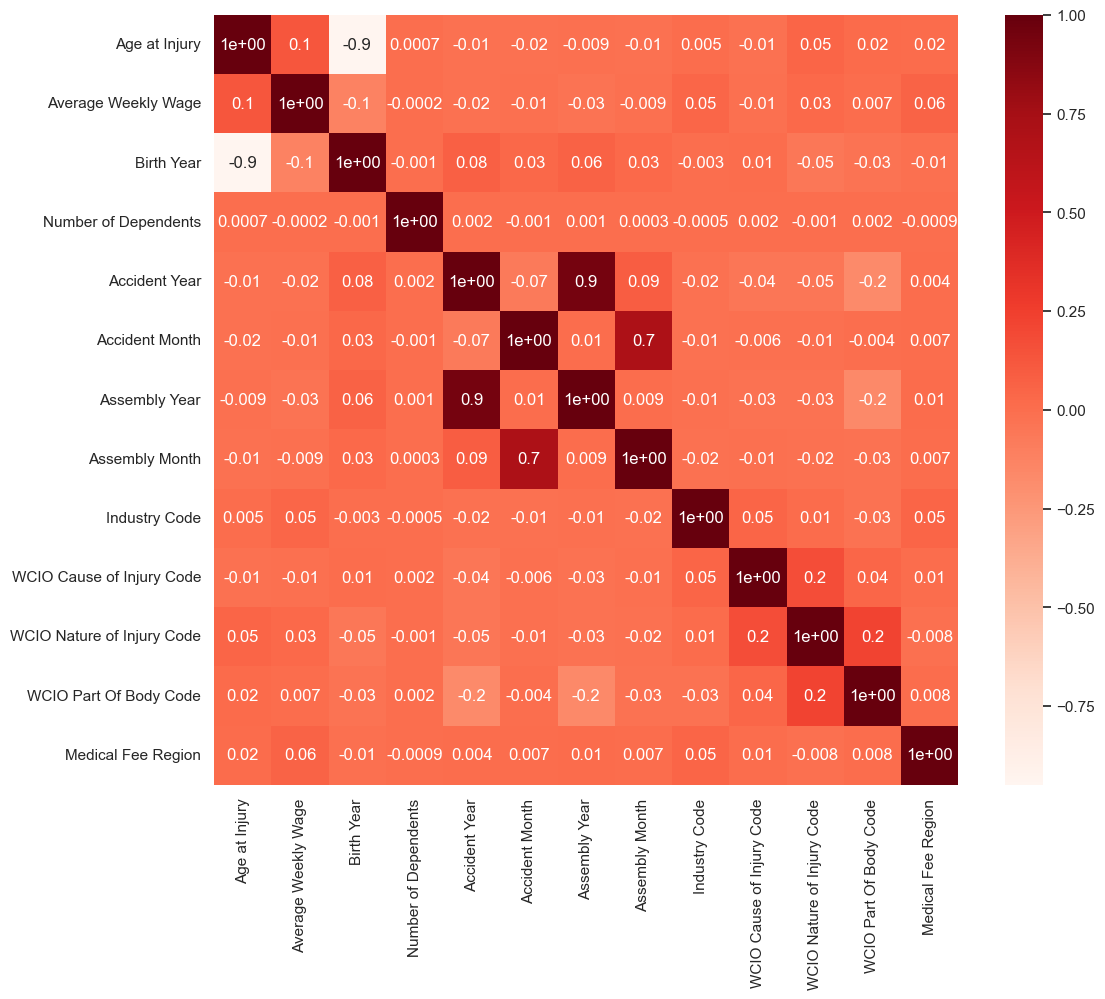

In [8]:
# get the spearman correlation matrix
corr_spearman = X_train_numeric_scaled.corr(method='spearman')
cor_heatmap(corr_spearman)

We can conclude that:

We need to use other feature selection techniques to get more insights.

There are two pairs of variables highly correlated, namely:
* Accident Year vs Assembly Year (0.9)
* Birth Year vs Age at Injury (-0.9)

## 4.2. Wrapper Methods

### 4.2.1. RFE

#### **4.2.1.1 RFE - Logistic Regression**

In [9]:
#Initialize the Logistic Regression model for RFE-Logistic Regression
model_LR = LogisticRegression()

# Initialize the Recursive Feature Elimination (RFE) selector
rfe_LR = RFE(estimator = model_LR, n_features_to_select = 3)

# Fit the RFE selector to the training data
X_rfe = rfe_LR.fit_transform(X = X_train_numeric_scaled, y = y_train_encoded)

# Get the selected features
rfelr_selected = X_train_numeric_scaled.columns[rfe_LR.support_]

In [10]:
rfelr_selected

Index(['Average Weekly Wage', 'Accident Year', 'WCIO Nature of Injury Code'], dtype='object')

#### **4.2.1.2. RFE - Cross-Validation**

In [11]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import pandas as pd

# Initialize the Logistic Regression model
model_CV = LogisticRegression()

# Define StratifiedKFold (stratified K-Folds cross-validator) with 5 splits
cv_strategy = StratifiedKFold(n_splits=5)


In [12]:
# Perform Recursive Feature Elimination with Cross-Validation (RFE-CV) using F1 score
rfecv = RFECV(estimator=model_CV, step=1, cv=cv_strategy, scoring='f1_weighted')  # Adjust scoring as needed

# Fit RFE-CV on the training data
rfecv.fit(X_train_numeric_scaled, y_train_encoded)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LogisticRegression(), scoring='f1_weighted')

In [13]:
# Optimal score
optimal_score = max(rfecv.cv_results_['mean_test_score'])

# Optimal number of features
print("Optimal number of features: %d" % rfecv.n_features_)

# Performance
print("Score with %d features: %f" % (rfecv.n_features_, optimal_score))

# Print the ranking of features
print("Feature ranking:", rfecv.ranking_)


Optimal number of features: 11
Score with 11 features: 0.654561
Feature ranking: [2 1 1 3 1 1 1 1 1 1 1 1 1]


In [14]:
# Create a DataFrame with the support and ranking of features
rfecv_selected = pd.DataFrame(
    {"support": rfecv.support_, "ranking": rfecv.ranking_}, 
    index=X_train_numeric_scaled.columns
)

# Filter the DataFrame to get only the features with a rank of 1
important_features = rfecv_selected[rfecv_selected['ranking'] == 1]

# Print the important features
print("Important features selected by RFECV:")
print(important_features)

Important features selected by RFECV:
                            support  ranking
Average Weekly Wage            True        1
Birth Year                     True        1
Accident Year                  True        1
Accident Month                 True        1
Assembly Year                  True        1
Assembly Month                 True        1
Industry Code                  True        1
WCIO Cause of Injury Code      True        1
WCIO Nature of Injury Code     True        1
WCIO Part Of Body Code         True        1
Medical Fee Region             True        1


Visualizing feature: County of Injury


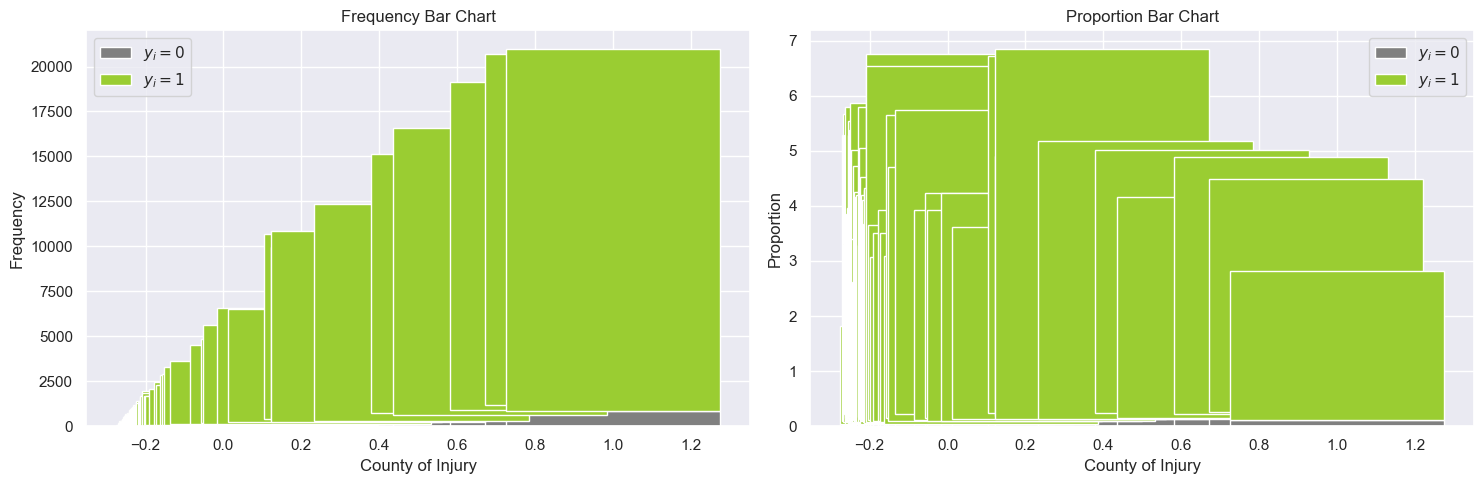

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Filter categorical features to include only those in X_train_encoded
categorical_features = [col for col in categorical_features if col in X_train_encoded.columns]

# Combine categorical features and target variable
all_train = X_train_encoded[categorical_features].join(y_train_encoded)

# Function for bar chart visualization
def bar_charts_categorical(df, feature, target):
    """
    Create bar charts showing the frequency and proportion of a dependent variable
    for each category of a given categorical feature.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the feature and target variable
    - feature (str): The name of the categorical feature
    - target (str): The name of the dependent variable
    """
    # Create a contingency table for the feature and target variable
    cont_tab = pd.crosstab(df[feature], df[target], margins=True)
    categories = cont_tab.index[:-1]  # Exclude 'All' row
    
    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # First subplot: Frequency bar chart
    axes[0].bar(categories, cont_tab.iloc[:-1, 0].values, 0.55, color="gray", label='$y_i=0$')
    axes[0].bar(categories, cont_tab.iloc[:-1, 1].values, 0.55, bottom=cont_tab.iloc[:-1, 0], color="yellowgreen", label='$y_i=1$')
    axes[0].set_title("Frequency Bar Chart")
    axes[0].set_xlabel(feature)
    axes[0].set_ylabel("Frequency")
    axes[0].legend()
    
    # Calculate proportions for the second subplot
    obs_pct = np.array([
        np.divide(cont_tab.iloc[:-1, 0].values, cont_tab.iloc[:-1, 2].values),
        np.divide(cont_tab.iloc[:-1, 1].values, cont_tab.iloc[:-1, 2].values)
    ])
    
    # Second subplot: Proportion bar chart
    axes[1].bar(categories, obs_pct[0], 0.55, color="gray", label='$y_i=0$')
    axes[1].bar(categories, obs_pct[1], 0.55, bottom=obs_pct[0], color="yellowgreen", label='$y_i=1$')
    axes[1].set_title("Proportion Bar Chart")
    axes[1].set_xlabel(feature)
    axes[1].set_ylabel("Proportion")
    axes[1].legend()
    
    # Display the plots
    plt.tight_layout()
    plt.show()

# Loop through filtered categorical features
for feature in categorical_features:
    print(f"Visualizing feature: {feature}")
    bar_charts_categorical(all_train, feature=feature, target=y_train_encoded.columns[0])  # Adjust target name if necessary


In [16]:
'''#Initialize the Logistic Regression model for RFE-Cross-Validation
model_CV = LogisticRegression()

#Define StratifiedKFold (stratified K-Folds cross-validator) with 5 splits
cv_strategy = StratifiedKFold(n_splits=5) 

#Perform Recursive Feature Elimination with Cross-Validation (RFE-CV)
rfecv = RFECV(estimator=model_CV, step=1, cv=cv_strategy, scoring='accuracy')  

#Fit RFE-CV on the training data
rfecv.fit(X_train_numeric_scaled, y_train_encoded)

#Optimal score
optimal_score = max(rfecv.cv_results_['mean_test_score'])

#Optimal number of features
print("Optimal number of features: %d" % rfecv.n_features_)

# performance
print("Score with %d features: %f" % (rfecv.n_features_, optimal_score))

SyntaxError: incomplete input (2136208630.py, line 1)

In [ ]:
'''# Print the ranking of features
# Features with a rank of 1 are the most important features selected by the RFE-CV process and higher ranks are less important
print("Feature ranking:", rfecv.ranking_)

In [ ]:
'''# Create a DataFrame with the support and ranking of features
rfecv_selected = pd.DataFrame({"support": rfecv.support_, "ranking": rfecv.ranking_}, index=X_train_numeric_scaled.columns)

# Filter the DataFrame to get only the features with a rank of 1
important_features = rfecv_selected[rfecv_selected['ranking'] == 1]

# Print the important features
print("Important features selected by RFECV:")
print(important_features)

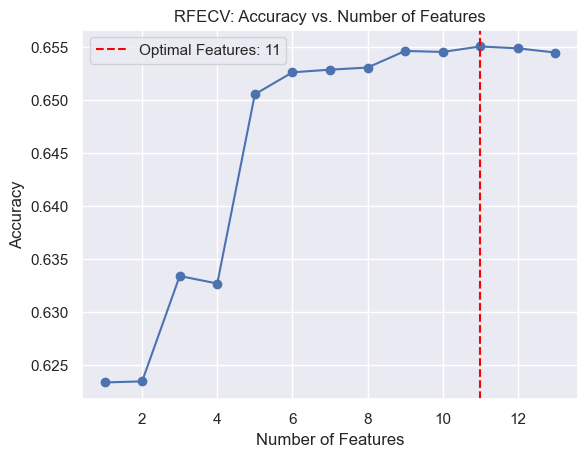

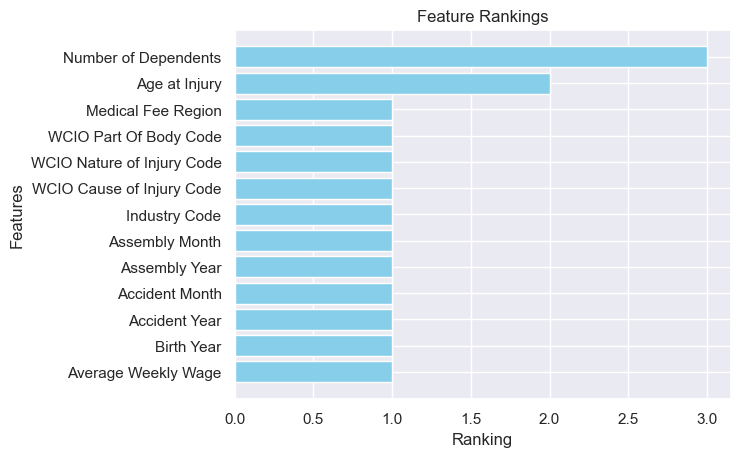

Selected Features (Rank = 1):
                       Feature  Ranking
1          Average Weekly Wage        1
2                   Birth Year        1
4                Accident Year        1
5               Accident Month        1
6                Assembly Year        1
7               Assembly Month        1
8                Industry Code        1
9    WCIO Cause of Injury Code        1
10  WCIO Nature of Injury Code        1
11      WCIO Part Of Body Code        1
12          Medical Fee Region        1


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Plot Cross-Validation Score vs. Number of Features
def plot_rfecv_scores(rfecv):
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'], marker='o')
    plt.axvline(rfecv.n_features_, color='red', linestyle='--', label=f'Optimal Features: {rfecv.n_features_}')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title('RFECV: Accuracy vs. Number of Features')
    plt.legend()
    plt.show()

# Plot Feature Rankings
def plot_feature_rankings(rfecv, X_train):
    rankings = pd.DataFrame({'Feature': X_train.columns, 'Ranking': rfecv.ranking_}).sort_values(by='Ranking')
    selected_features = rankings[rankings['Ranking'] == 1]
    
    plt.barh(rankings['Feature'], rankings['Ranking'], color='skyblue')
    plt.xlabel('Ranking')
    plt.ylabel('Features')
    plt.title('Feature Rankings')
    plt.show()

    print("Selected Features (Rank = 1):")
    print(selected_features)

# Call the functions
plot_rfecv_scores(rfecv)
plot_feature_rankings(rfecv, X_train_numeric_scaled)


## 4.3 Embedded Methods

### **4.3.1 Lasso Regression**

In [ ]:
# Initialize the Lasso model 
reg = LassoCV()

# Fit the Lasso model to the training data
reg.fit(X_train_numeric_scaled, y_train_encoded)

LassoCV()

In [ ]:
# Get the coefficients of the Lasso model
coef = pd.Series(reg.coef_, index = X_train_numeric_scaled.columns)
coef

Age at Injury                -0.000000
Average Weekly Wage           2.660399
Birth Year                   -0.016598
Number of Dependents          0.000000
Accident Year                -0.059952
Accident Month               -0.000000
Assembly Year                -0.132619
Assembly Month               -0.053077
Industry Code                -0.127269
WCIO Cause of Injury Code    -0.136813
WCIO Nature of Injury Code   -0.068708
WCIO Part Of Body Code       -0.064578
Medical Fee Region           -0.057597
dtype: float64

In [ ]:
# Sort the coefficients by their absolute values
sorted_coef = coef.abs().sort_values(ascending=False)

In [ ]:
# Function to plot feature importance according to Lasso
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

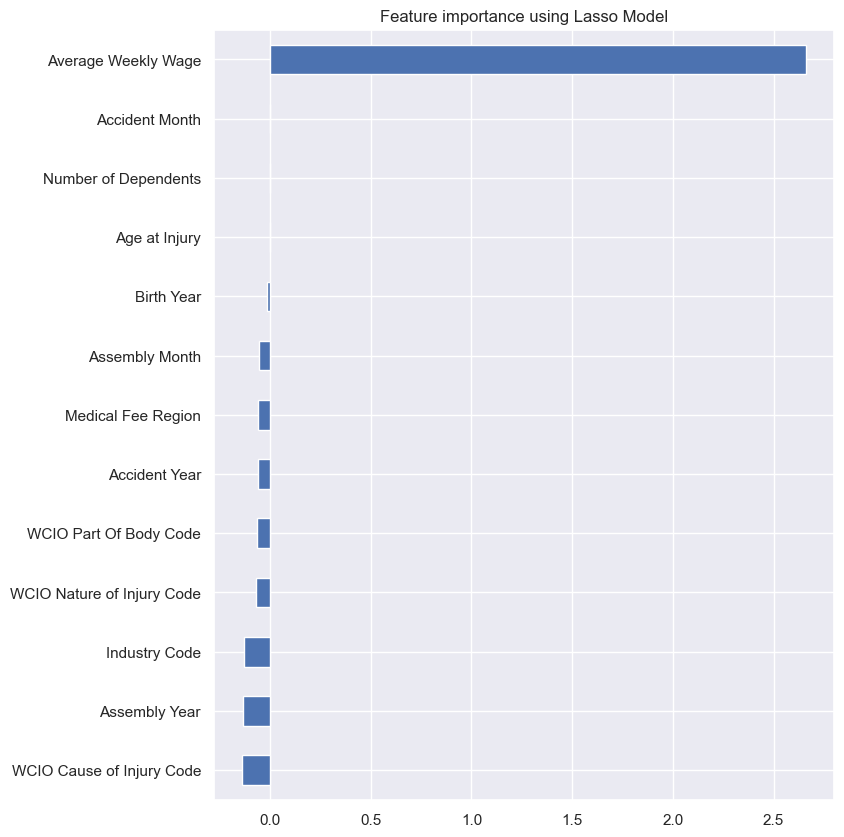

In [ ]:
plot_importance(coef,'Lasso')

Keeping the 4 features with the highest absolute value for the Lasso Model.

### **4.3.3 Gradient Boosting**

In [ ]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_numeric_scaled, y_train_encoded)

# Get feature importances
importances = gb_model.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': X_train_numeric_scaled.columns,
    'Importance': importances
})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display feature importances
print(feature_importances)


                       Feature  Importance
1          Average Weekly Wage    0.888394
11      WCIO Part Of Body Code    0.033687
10  WCIO Nature of Injury Code    0.025330
8                Industry Code    0.023858
4                Accident Year    0.011977
9    WCIO Cause of Injury Code    0.010102
6                Assembly Year    0.001983
0                Age at Injury    0.001527
12          Medical Fee Region    0.001458
5               Accident Month    0.000786
7               Assembly Month    0.000460
2                   Birth Year    0.000420
3         Number of Dependents    0.000017


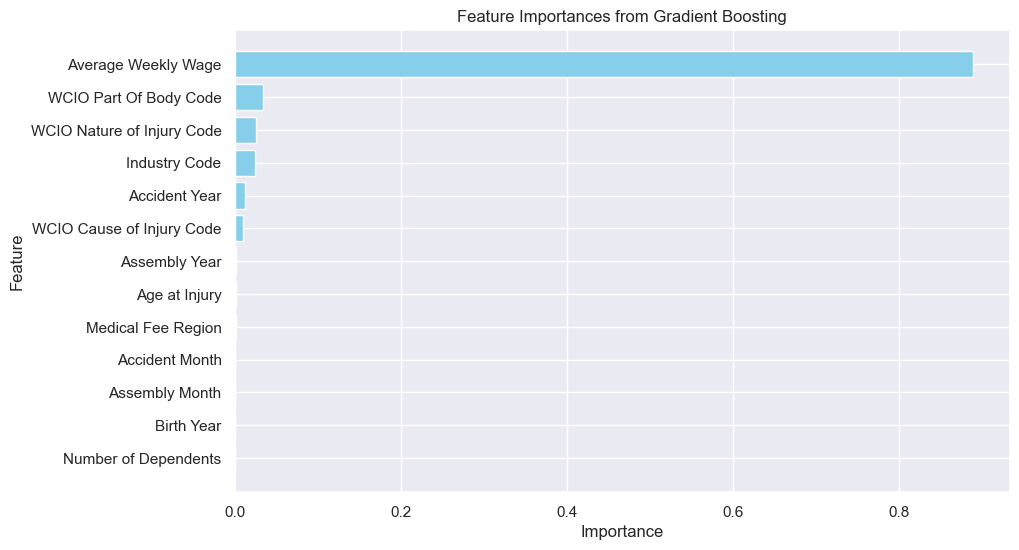

In [ ]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Gradient Boosting')
plt.gca().invert_yaxis()  # Reverse the y-axis so the most important feature is at the top
plt.show()


Keeping only the highest important feature with more than 0.8 of importance value. The other features are under 0.1 which is a big gap.

Keeping the 4 features above the 20000 treshold. 

### **4.3.5 Random Forest**

In [ ]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_numeric_scaled, y_train_encoded)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importances_rf = pd.DataFrame({
    'Feature': X_train_numeric_scaled.columns,
    'Importance': importances
})

# Sort features by importance
feature_importances_rf = feature_importances_rf.sort_values(by='Importance', ascending=False)

# Display feature importances
print(feature_importances_rf)

                       Feature  Importance
1          Average Weekly Wage    0.411198
0                Age at Injury    0.071214
2                   Birth Year    0.067604
9    WCIO Cause of Injury Code    0.067588
11      WCIO Part Of Body Code    0.063684
8                Industry Code    0.059704
7               Assembly Month    0.052703
3         Number of Dependents    0.052192
5               Accident Month    0.052178
10  WCIO Nature of Injury Code    0.042051
12          Medical Fee Region    0.028794
4                Accident Year    0.018215
6                Assembly Year    0.012874


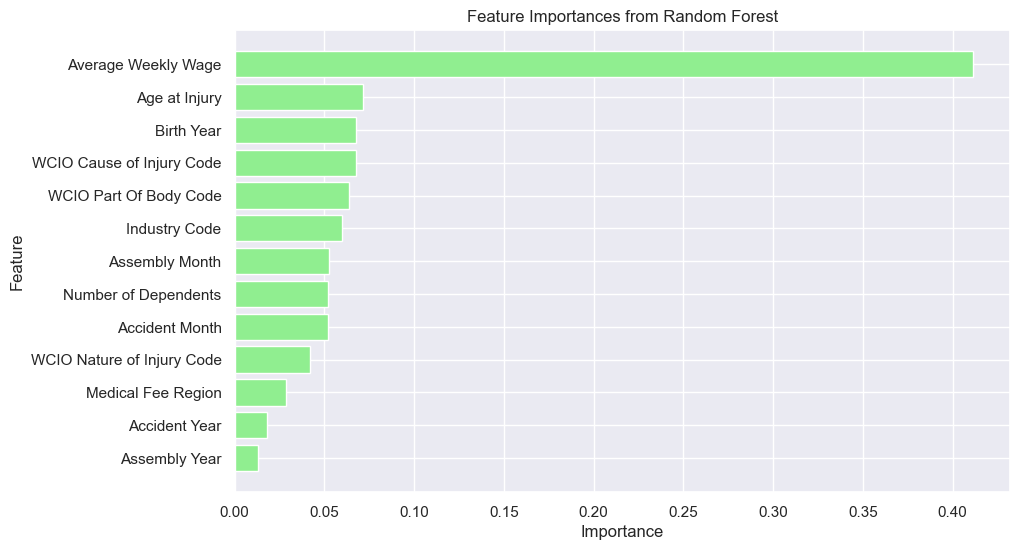

In [ ]:
# plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_rf['Feature'], feature_importances_rf['Importance'], color='lightgreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # reverse the y-axis so that the most important feature is at the top
plt.show()


Keeping the 2 features with the highest importance value. The others are under 0.1, too close to 0 considering one of the features got almost 0.35


## Categorical

### **4.3.6 Chi Square**

Important Features:
                                              Feature  Chi-Square Score  \
0                                Carrier Type_2A. SIF       6187.357944   
1                        Carrier Type_3A. SELF PUBLIC       8366.611319   
2                       Carrier Type_4A. SELF PRIVATE        984.846017   
3   Carrier Type_5A. SPECIAL FUND - CONS. COMM. (S...        108.813707   
5             Carrier Type_5D. SPECIAL FUND - UNKNOWN        198.587969   
6                                Carrier Type_UNKNOWN       1126.807315   
7                            District Name_BINGHAMTON        792.636503   
8                               District Name_BUFFALO        217.553219   
9                             District Name_HAUPPAUGE       1144.698389   
10                                  District Name_NYC       1707.190573   
11                            District Name_ROCHESTER        907.756984   
12                            District Name_STATEWIDE       1008.194116   
13   

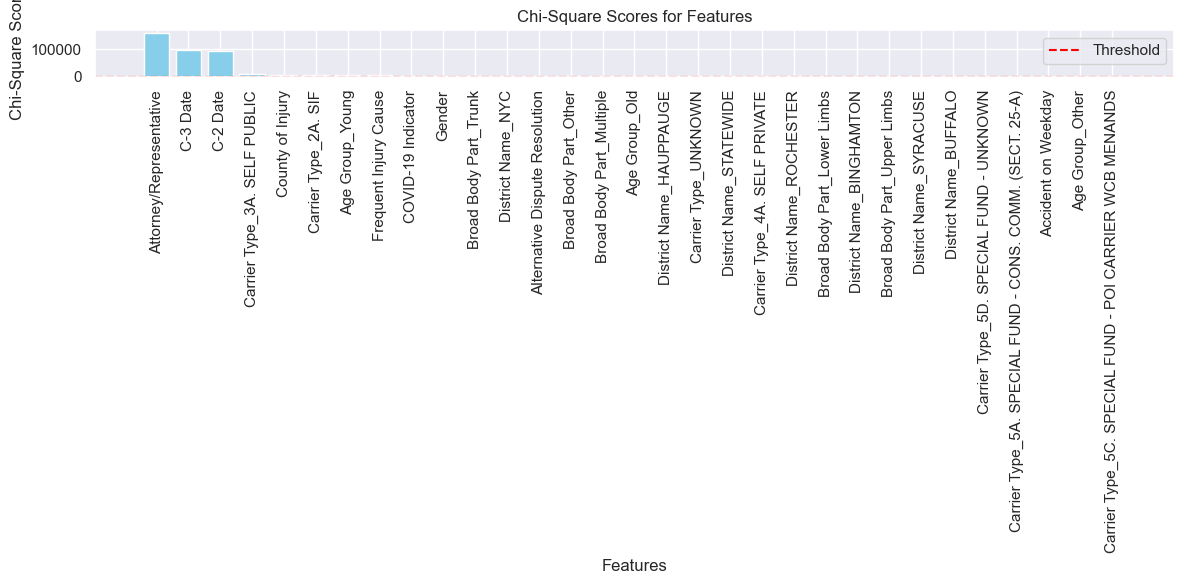

In [ ]:
from scipy.stats import chi2_contingency
import pandas as pd
import matplotlib.pyplot as plt

def test_independence(X, y, alpha=0.0001):
    """
    Perform Chi-Square tests for independence for all categorical features.

    Parameters:
    - X: Feature matrix (categorical features only, pd.DataFrame)
    - y: Target variable (1D array or pd.Series)
    - alpha: Significance level for the Chi-Square test (default: 0.0001)

    Returns:
    - results_df: DataFrame containing features, Chi-Square scores, p-values, and importance.
    """
    results = []

    for var in X.columns:
        # Create a contingency table
        contingency_table = pd.crosstab(y, X[var])

        # Perform Chi-Square test
        chi2, p, _, _ = chi2_contingency(contingency_table.values)

        # Determine feature importance
        importance = "Important" if p < alpha else "Not Important"

        # Store the results
        results.append({
            'Feature': var,
            'Chi-Square Score': chi2,
            'p-Value': p,
            'Importance': importance
        })

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    return results_df

def plot_chi2_results(results_df):
    """
    Plot the Chi-Square scores of the features.

    Parameters:
    - results_df: DataFrame containing Chi-Square results.
    """
    important_features = results_df[results_df['Importance'] == "Important"]
    unimportant_features = results_df[results_df['Importance'] == "Not Important"]

    # Sort by Chi-Square Score
    results_df = results_df.sort_values(by='Chi-Square Score', ascending=False)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(results_df['Feature'], results_df['Chi-Square Score'], color='skyblue')
    plt.axhline(y=important_features['Chi-Square Score'].min(), color='red', linestyle='--', label="Threshold")
    plt.title("Chi-Square Scores for Features")
    plt.xlabel("Features")
    plt.ylabel("Chi-Square Score")
    plt.xticks(rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Usage
chi2_results_df = test_independence(X_train_categorical_encoded, y_train_encoded.values.ravel())

# Print important features
important_features = chi2_results_df[chi2_results_df['Importance'] == "Important"]
print("Important Features:")
print(important_features)

# Plot the results
plot_chi2_results(chi2_results_df)


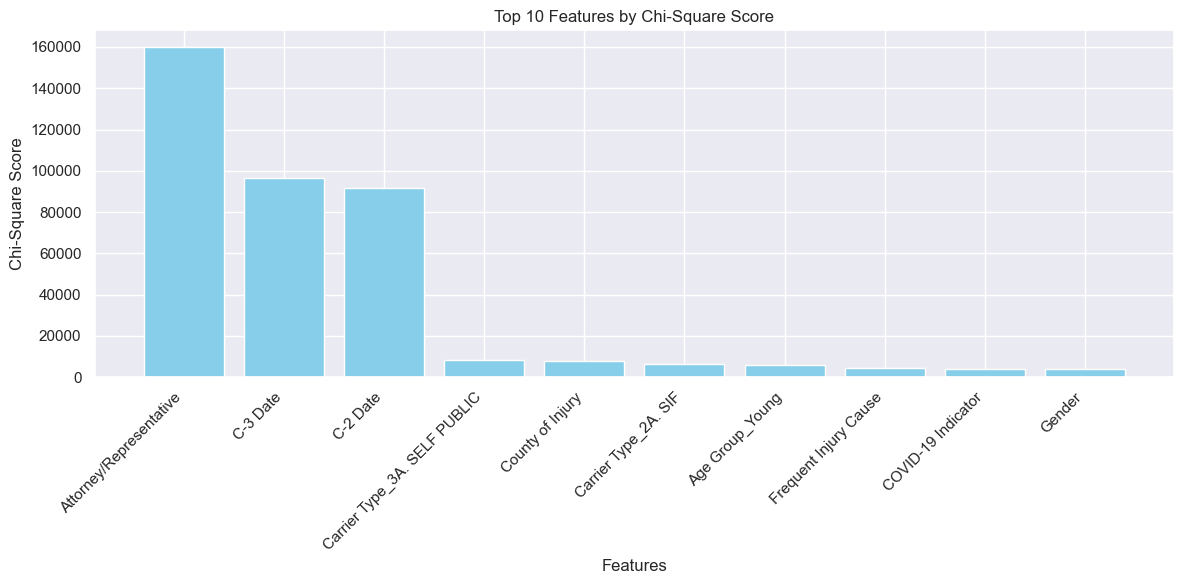

In [ ]:
def plot_top_chi2_results(results_df, top_n=10):
    """
    Plot the top N features based on Chi-Square scores.

    Parameters:
    - results_df: DataFrame containing Chi-Square results.
    - top_n: Number of top features to display (default: 10).
    """
    # Filter important features and sort by Chi-Square score
    top_features = results_df.sort_values(by='Chi-Square Score', ascending=False).head(top_n)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(top_features['Feature'], top_features['Chi-Square Score'], color='skyblue')
    plt.title(f"Top {top_n} Features by Chi-Square Score")
    plt.xlabel("Features")
    plt.ylabel("Chi-Square Score")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Usage: Visualize top 10 important features
plot_top_chi2_results(chi2_results_df, top_n=10)


In [ ]:
# List to store chi-square test results
chi2_results = []

def TestIndependence(X, y, var, alpha=0.0001):
    # Create a contingency table (observed frequencies)
    dfObserved = pd.crosstab(y, X)

    # Perform the chi-square test of independence
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)

    # Determine the importance based on the p-value
    if p < alpha:
        importance = "Important"
    else:
        importance = "Not Important"

    # Append the results to the chi2_results list
    chi2_results.append({
        'Feature': var,
        'Chi-Square Score': chi2,
        'Importance': importance
    })

    # Print the result for the feature
    print(f"{var} is {importance} for Prediction")


In [ ]:
# Loop through each categorical feature in the training data
for var in X_train_categorical_encoded.columns:
    # Perform the chi-square test of independence for the current feature
    TestIndependence(X_train_categorical_encoded[var], y_train_encoded.values.ravel(), var)

Carrier Type_2A. SIF is Important for Prediction
Carrier Type_3A. SELF PUBLIC is Important for Prediction
Carrier Type_4A. SELF PRIVATE is Important for Prediction
Carrier Type_5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A) is Important for Prediction
Carrier Type_5C. SPECIAL FUND - POI CARRIER WCB MENANDS is Not Important for Prediction
Carrier Type_5D. SPECIAL FUND - UNKNOWN is Important for Prediction
Carrier Type_UNKNOWN is Important for Prediction
District Name_BINGHAMTON is Important for Prediction
District Name_BUFFALO is Important for Prediction
District Name_HAUPPAUGE is Important for Prediction
District Name_NYC is Important for Prediction
District Name_ROCHESTER is Important for Prediction
District Name_STATEWIDE is Important for Prediction
District Name_SYRACUSE is Important for Prediction
Age Group_Old is Important for Prediction
Age Group_Other is Not Important for Prediction
Age Group_Young is Important for Prediction
Broad Body Part_Lower Limbs is Important for Prediction


In [ ]:
# Convert the list of chi-square test results to a DataFrame
chi2_df = pd.DataFrame(chi2_results).sort_values(by='Chi-Square Score', ascending=False)

# Print the DataFrame containing the chi-square test results
print(chi2_df)

                                              Feature  Chi-Square Score  \
24                            Attorney/Representative     160032.049940   
26                                           C-3 Date      96737.033199   
25                                           C-2 Date      91723.213776   
1                        Carrier Type_3A. SELF PUBLIC       8366.611319   
22                                   County of Injury       7974.961271   
0                                Carrier Type_2A. SIF       6187.357944   
16                                    Age Group_Young       5643.307646   
30                              Frequent Injury Cause       4632.787771   
27                                 COVID-19 Indicator       4047.752149   
28                                             Gender       3699.824292   
20                              Broad Body Part_Trunk       3591.204529   
10                                  District Name_NYC       1707.190573   
23                     Al

In [ ]:
#Check the value counts of the 'Important' features

important_categorical_features = chi2_df[chi2_df['Importance'] == 'Important']['Feature']

print(important_categorical_features)

24                              Attorney/Representative
26                                             C-3 Date
25                                             C-2 Date
1                          Carrier Type_3A. SELF PUBLIC
22                                     County of Injury
0                                  Carrier Type_2A. SIF
16                                      Age Group_Young
30                                Frequent Injury Cause
27                                   COVID-19 Indicator
28                                               Gender
20                                Broad Body Part_Trunk
10                                    District Name_NYC
23                       Alternative Dispute Resolution
19                                Broad Body Part_Other
18                             Broad Body Part_Multiple
14                                        Age Group_Old
9                               District Name_HAUPPAUGE
6                                  Carrier Type_

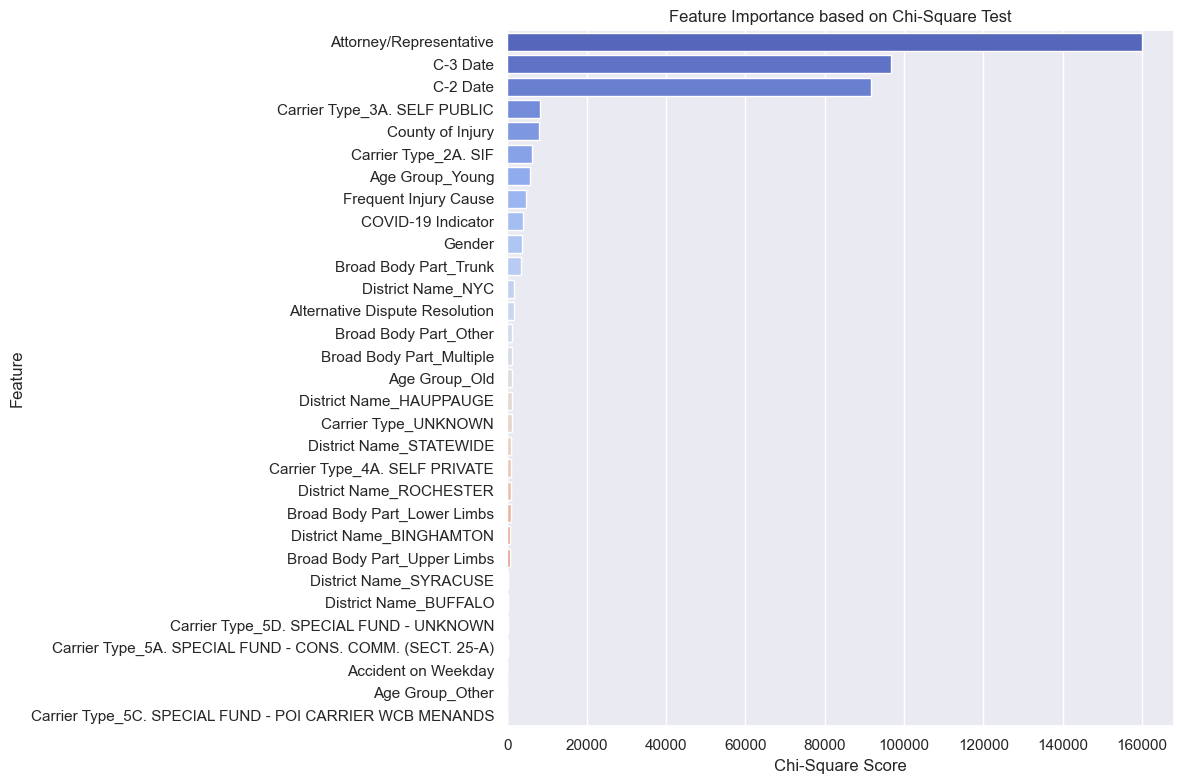

In [ ]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Chi-Square Score', y='Feature', data=chi2_df, palette='coolwarm')
plt.title("Feature Importance based on Chi-Square Test")
plt.xlabel("Chi-Square Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Keeping the first 5 most important features.
Even though that all 3 WCI0 are highly correlated.

### **4.3.7 Mutual Information**

In [ ]:
# Convert data to sparse matrix to save memory
X_train_sparse = csr_matrix(X_train_categorical_encoded)

# Perform Mutual Information feature selection
K = 'all'  # Set to an integer if you want to select the top-K features
selector = SelectKBest(score_func=mutual_info_classif, k=K)
X_train_selected = selector.fit_transform(X_train_sparse, y_train_encoded)

# Get the scores for each feature
mi_scores = selector.scores_

# Create a DataFrame for better visualization
feature_scores_mi = pd.DataFrame({
    'Feature': X_train_categorical_encoded.columns,
    'Mutual Information Score': mi_scores
})

# Sort features by their Mutual Information score
feature_scores_mi = feature_scores_mi.sort_values(by='Mutual Information Score', ascending=False)

# Display feature scores
print(feature_scores_mi)


                                              Feature  \
24                            Attorney/Representative   
26                                           C-3 Date   
25                                           C-2 Date   
22                                   County of Injury   
1                        Carrier Type_3A. SELF PUBLIC   
16                                    Age Group_Young   
0                                Carrier Type_2A. SIF   
27                                 COVID-19 Indicator   
30                              Frequent Injury Cause   
28                                             Gender   
20                              Broad Body Part_Trunk   
23                     Alternative Dispute Resolution   
10                                  District Name_NYC   
6                                Carrier Type_UNKNOWN   
19                              Broad Body Part_Other   
14                                      Age Group_Old   
9                             D

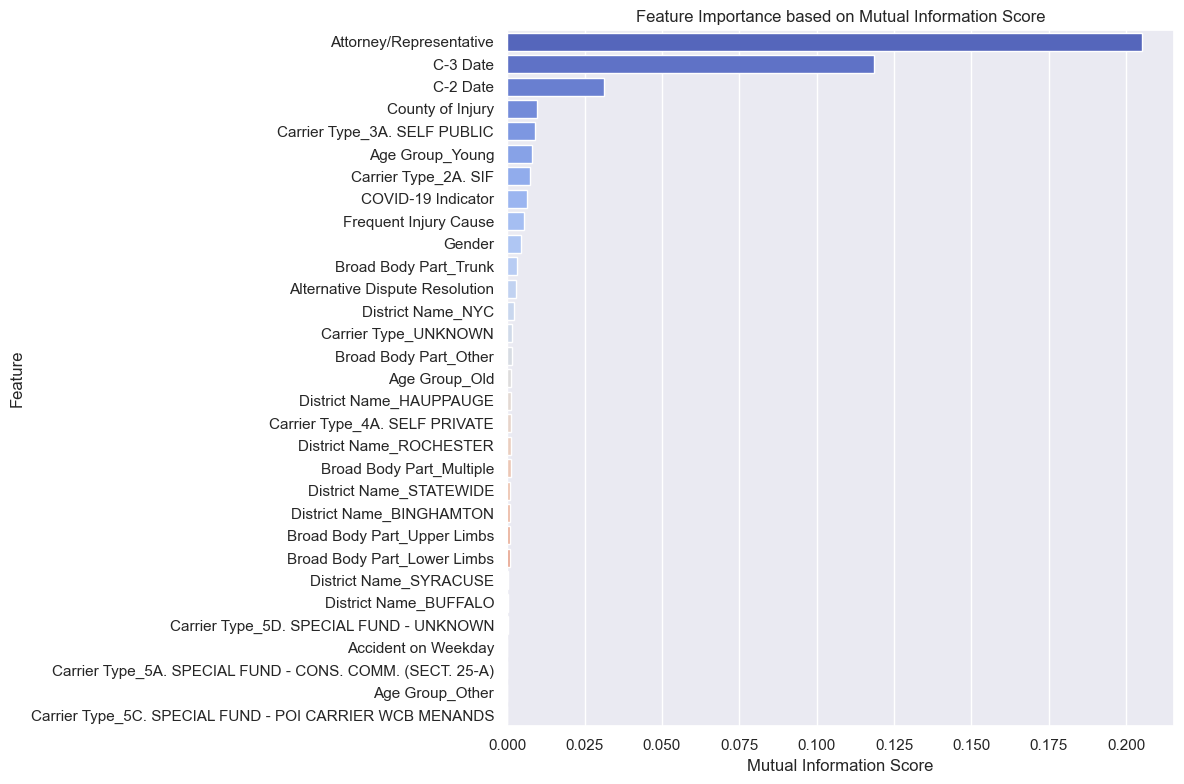

In [ ]:
# plot the mutual information scores
plt.figure(figsize=(12, 8))
sns.barplot(x='Mutual Information Score', y='Feature', data=feature_scores_mi, palette='coolwarm')
plt.title("Feature Importance based on Mutual Information Score")
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Keeping the 4 features with highest Mutual Information Score, because the others are approaching 0.

### **4.3.8 LASSO**

In [ ]:
# Convert the data to a sparse format
X_train_sparse = csr_matrix(X_train_categorical_encoded)

# Initialize and train the model with sparse data
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
lasso_model.fit(X_train_sparse, y_train_encoded)

# Extract non-zero coefficients for feature selection
coef_lasso = lasso_model.coef_[0]

# Create a DataFrame to store feature importances
feature_importances_lasso = pd.DataFrame({
    'Feature': X_train_categorical_encoded.columns,
    'Coefficient': coef_lasso
})

print(feature_importances_lasso.sort_values(by='Coefficient', ascending=False))

                                              Feature  Coefficient
25                                           C-2 Date     5.709231
26                                           C-3 Date     0.834750
24                            Attorney/Representative     0.512405
22                                   County of Injury     0.444798
12                            District Name_STATEWIDE     0.430647
17                        Broad Body Part_Lower Limbs     0.372316
10                                  District Name_NYC     0.281625
21                        Broad Body Part_Upper Limbs     0.263545
14                                      Age Group_Old     0.229828
0                                Carrier Type_2A. SIF     0.189457
29                                Accident on Weekday     0.085647
20                              Broad Body Part_Trunk     0.061607
15                                    Age Group_Other     0.060975
3   Carrier Type_5A. SPECIAL FUND - CONS. COMM. (S...     0.00

In [ ]:
print(lasso_model.coef_.shape)
print(lasso_model.coef_)


(8, 31)
[[ 1.89456892e-01 -3.03266902e-01 -5.58190567e-01  0.00000000e+00
   0.00000000e+00 -2.95271837e+00 -2.63352140e+00 -2.33552328e-01
  -1.42648483e-01 -7.51041763e-02  2.81625312e-01 -2.00867324e-01
   4.30646674e-01 -8.27267224e-02  2.29827923e-01  6.09750357e-02
  -3.84976991e-01  3.72315739e-01 -5.58972526e-02 -1.60343872e-01
   6.16068506e-02  2.63545196e-01  4.44797976e-01 -5.61805205e+00
   5.12404844e-01  5.70923074e+00  8.34750365e-01 -1.24973749e+00
  -2.98252691e-01  8.56473208e-02 -1.75092819e-01]
 [-4.66278687e-01  1.27793283e-01  1.00582557e-01 -3.84981954e-01
   0.00000000e+00  1.14519056e+00  4.04470062e+00 -1.98794289e-01
  -6.12707956e-02 -2.85022238e-01  2.80191106e-01  1.18475124e-02
  -1.44579762e-01 -1.25915964e-01 -5.76382801e-02  1.86008540e-02
   1.88442556e-01  7.25229963e-02  1.08179399e-01  1.43067780e-01
   2.62423835e-02  4.09273165e-01  1.07131623e-02  5.43058686e+00
  -2.56036929e+00 -1.68688436e-01  7.01624954e-01  7.36039827e-01
   2.05483459e-01

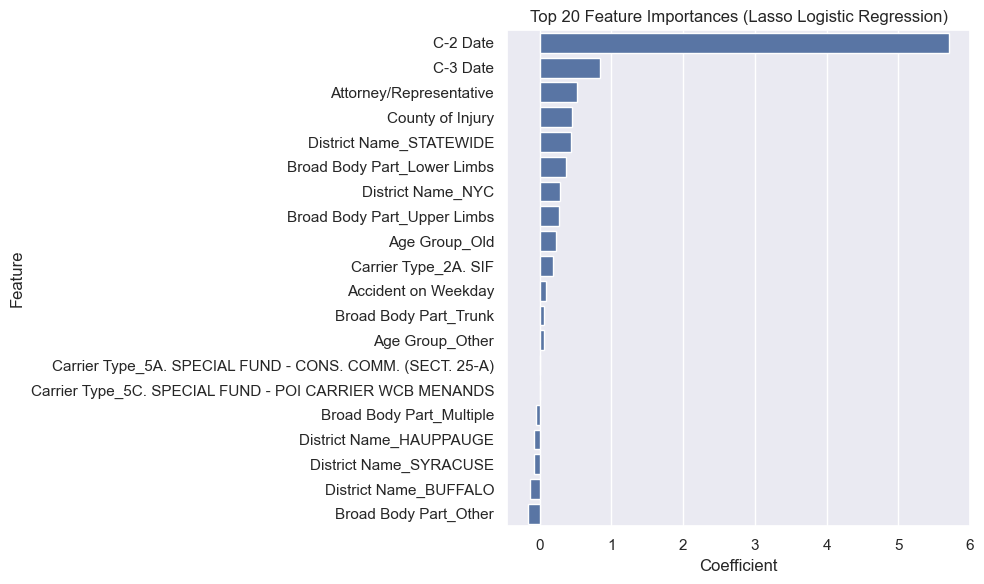

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the feature importances by absolute coefficient value
feature_importances_sorted = feature_importances_lasso.sort_values(by='Coefficient', ascending=False)

# Plot the top features
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Coefficient', 
    y='Feature', 
    data=feature_importances_sorted.head(20)  # Plot only the top 20 features for clarity
)
plt.title("Top 20 Feature Importances (Lasso Logistic Regression)")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


Keeping the 6 features with highest absolute coefficient value.

<a class="anchor" id="15th-bullet">

## Final Insights:
    
</a>

<hr>

### Numerical Data

| Predictor                       | Spearman | RFE LR  | RFE CV | Lasso | Decision Tree   | Gradient Boosting | ANOVA | Random Forest | What to do? (One possible way to "solve") |
|---------------------------------|----------|---------|--------|-------|-----------------|-------------------|-------|---------------|------------------------------------------|
| Age at Injury                   | Keep? | Discard | Discard| Discard| Discard| Discard | Discard|Discard |Not include in the model
| Attorney/Representative         | Keep | Discard | Keep| Keep   | Discard| Discard|  Keep|Discard|Try with and without 
| Average Weekly Wage             | Keep | Keep    | Keep| Keep   | Keep| Keep|Keep|  Keep |Include in the model
| Birth Year                      | Keep?| Discard | Keep| Discard| Discard| Discard| Discard| Discard | Not include in the model
| C-2 Date                        | Keep | Keep    | Keep| Keep| Discard| Discard| Keep| Discard  |Include in the model
| C-3 Date                        | Keep | Discard | Keep| Discard| Discard|Discard| Keep| Discard  |Not include in the model
| Claim Identifier                | Keep | Discard | Keep| Discard| Keep|Discard| Discard|   Keep |Try with and without 
| COVID-19 Indicator              | Discard | Keep    | Keep| Keep| Discard|Discard| Discard|  Discard|Not include in the model
| Industry Code                   | Keep | Discard | Keep| Discard| Discard|Discard | Discard |Discard | Not include in the model
| WCIO Cause of Injury Code       | Keep | Discard | Keep| Discard| Discard|Discard| Discard|       Discard  | Not include in the model 
| WCIO Nature of Injury Code      | Keep | Discard | Keep| Discard| Discard|Discard| Discard|Discard   |Not include in the model 
| WCIO Part Of Body Code          | Keep | Discard | Discard| Discard   | Discard|Discard| Discard|  Discard | Not include in the model 
| Number of Dependents            | Keep | Discard | Discard| Discard| Discard|            Discard      | Discard   | Discard | Not include in the model  
| Frequent Injury Cause           | Keep | Discard | Keep| Discard   | Discard| Discard          |  Discard   | Discard    | Not include in the model


<hr>


### Categorical Data

| Predictor                          | Chi-Square | Mutual Information | ANOVA  | Lasso  | What to do? (One possible way to "solve") |
| -----------------------------------|------------|--------------------|--------------------|-------------|-------------|
| Accident Date                      | Keep       |Discard|     Discard  |Discard|Not include in the model
| Assembly Date                      | Discard       |Discard|         Discard  |  Discard  |Not include in the model|
| Carrier Name                       | Keep|Keep|   Discard |Discard| Try with and without 
| Carrier Type                       | Discard       |Discard|           Keep |Keep|Try with and without 
| County of Injury                   | Discard       |    Discard                |   Discard      | Discard  |Not include in the model|
| District Name                      | Discard       |Discard|           Discard |Discard|Not include in the model
| Gender                             | Discard       |    Discard                |       Keep   |Keep |Try with and without|
| Industry Code Description          | Discard       |    Discard                |  Keep      | Keep |Try with and without|
| Medical Fee Region                 | Discard       |    Discard                |     Discard     | Keep |Not include in the model|
| WCIO Cause of Injury Description   | Keep|Keep |Discard |Discard|Try with and without
| WCIO Nature of Injury Description  | Keep       |Keep  |Discard|Discard|Try with and without
| WCIO Part Of Body Description      | Keep       |Keep|    Discard        |Discard|Try with and without|
| Age Group     | Keep       |Keep|Keep|Keep|Include in the model
| Broad Body Part    | Keep       |Keep| Discard |Keep|Include in the model


<hr>



**Final Dataframe with features to keep**

In [ ]:
numerical_selected = ['Average Weekly Wage']

categorical_selected = chi2_df[chi2_df['Importance'] == 'Important']['Feature'].tolist()

final_numerical_train = X_train_numeric_scaled[numerical_selected]
final_categorical_train = X_train_categorical_encoded[categorical_selected]

final_df_train = pd.concat([final_numerical_train, final_categorical_train], axis=1)

final_numerical_val = X_val_numeric_scaled[numerical_selected]
final_categorical_val = X_val_categorical_encoded[categorical_selected]

final_df_val = pd.concat([final_numerical_val, final_categorical_val], axis=1)
final_df_test= X_test_encoded

In [ ]:
final_df_train.to_csv('datasets/final_data_train_delivery1.csv')
final_df_val.to_csv('datasets/final_data_val_delivery1.csv')